# Forecasting 


In this lesson, we will practice forecasting using the following methods:  

- Last observed value  
- Simple average  
- Moving average  
- Holt's Linear Trend  
- Previous cycle  

______________________________


We will walk through steps from previous lessons to get the data ready to model

- Acquire data: prepare.acquire_store_data()  
- Prepare data: prepare.prep_store_data()  
- Split data: prepare.split_store_data()  

Then we will forecast and evaluate using each method. 

In [2]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# working with dates
from datetime import datetime

# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 

# for tsa 
import statsmodels.api as sm

# holt's linear trend model. 
from statsmodels.tsa.api import Holt

## Wrangle


In [3]:
# read csv
df = pd.read_csv('combined.csv')

# look at first 5 rows, transposed. 
df.head().T

,0,1,2,3,4
item_id,1,1,1,1,1
sale_amount,13.0,11.0,14.0,13.0,10.0
sale_date,"Tue, 01 Jan 2013 00:00:00 GMT","Wed, 02 Jan 2013 00:00:00 GMT","Thu, 03 Jan 2013 00:00:00 GMT","Fri, 04 Jan 2013 00:00:00 GMT","Sat, 05 Jan 2013 00:00:00 GMT"
sale_id,1,2,3,4,5
store_id,1,1,1,1,1
store_address,12125 Alamo Ranch Pkwy,12125 Alamo Ranch Pkwy,12125 Alamo Ranch Pkwy,12125 Alamo Ranch Pkwy,12125 Alamo Ranch Pkwy
store_city,San Antonio,San Antonio,San Antonio,San Antonio,San Antonio
store_state,TX,TX,TX,TX,TX
store_zipcode,78253,78253,78253,78253,78253
item_brand,Riceland,Riceland,Riceland,Riceland,Riceland


**To Do to Prep**

1. sale_date to datetime
2. sort values by date
3. set index
4. new field: dollars_sold = sale_amount * item_price
5. rename sale_amount to items_sold to make the two columns easier to understand what the data represents. 
6. resample daily (The original granularity is daily, but there are multiple records of the same days across multiple stores.)
7. remove leap days!


We will resample to daily, but essentially what we are doing is grouping by the day and aggregating using sum. The original granularity is daily, but there are multiple records of the same days across multiple stores. 

In [4]:

# write function to prep the data:

def prep_data(df):
    '''
    The function takes in a dataframe and returns a dataframe with 
    the dates as index, aggregated by summing at the daily level,
    changing the sale_amount column namme to be items_sold, 
    creating a new feature of dollars_sold (sale_amount * item_price)
    and removing the leap day. 
    '''
    # convert sale_date to datetime format
    df['ds'] = pd.to_datetime(df.sale_date.apply(lambda x: x[:-13]))
    
    # sort values by date
    df = df.sort_values('ds')
    
    # set index
    df = df.set_index('ds')
    
    # new field dollars_sold = sale_amount * item_price 
    df['dollars_sold'] = df.sale_amount * df.item_price

    # rename sale_amount to items_sold, and drop original column of sale_amount
    df = df.assign(items_sold = df.sale_amount).drop(columns=['sale_amount'])
    
    # aggregate or resample daily by summing dollars & items sold
    df_resampled = df.resample('d')[['dollars_sold','items_sold']].sum()

    # remove leap day
    df_resampled = df_resampled[df_resampled.index != '2016-02-29']
    
    return df_resampled

In [5]:
df = prep_data(df)

In [6]:
df.head()

,dollars_sold,items_sold
ds,,
2013-01-01,73844.01,13696.0
2013-01-02,73570.58,13678.0
2013-01-03,78169.48,14488.0
2013-01-04,84467.73,15677.0
2013-01-05,87621.85,16237.0


In [ ]:
# check and make sure you got what you were expecting

In [ ]:
df.head()

## Split

1. We will use the training proportion method to split.    
2. Identify the total length of the dataframe and multiply by `train_prop` to get the number of rows that equates to the first x% of the dataframe, which equates to the first x% of the time covered in the data.   (`x = train_prop * 100`)  
3. Select row indices from 0 up to the index representing x-percentile for train, and from the index representing x-percentile through the end of the dataframe for test. In both of these, we will reset the index in order to return dataframes sorted by datetime.  
4. Return train and test dataframes.  

In [7]:
# set train size to be 50% of total 
train_size = int(len(df)*0.5)
train_size

912

In [8]:
# set validate size to be 30% of total 
validate_size = int(len(df)*0.3)
validate_size

547

In [9]:
# set test size to be number of rows remaining. 
test_size = int(len(df)-train_size - validate_size)
test_size

366

In [10]:
# validate will go from 912 to 912+547
validate_end_index = train_size + validate_size
validate_end_index

1459

Use those values to split our dataframe

In [11]:
# train will go from 0 to 911
train = df[:train_size]
# validate will go from 912 to 1458
validate = df[train_size:validate_end_index]
# test will include 1459 to the end
test = df[validate_end_index:]

**Verify Splits**

Does the length of each df equate to the length of the original df? 

In [12]:
# is len of train + validate + test == lenght of entire dataframe. 
print(len(train) + len(validate) + len(test) == len(df))

True


Does the first row of original df equate to the first row of train? 

In [13]:
print(df.head(1) == train.head(1))

            dollars_sold  items_sold
ds                                  
2013-01-01          True        True


Is the last row of train the day before the first row of validate? And the same for validate to test? 

In [14]:
pd.concat([train.tail(1), validate.head(1)])

,dollars_sold,items_sold
ds,,
2015-07-01,164573.20,30703.0
2015-07-02,178036.64,33134.0


-
-
-
-
-
-
-
-
-
-









In [15]:
pd.concat([validate.tail(1), test.head(1)])

,dollars_sold,items_sold
ds,,
2016-12-30,120033.64,22296.0
2016-12-31,128009.31,23792.0


Is the last row of test the same as the last row of our original dataframe? 

In [16]:
pd.concat([test.tail(1), df.tail(1)])

,dollars_sold,items_sold
ds,,
2017-12-31,140905.74,26420.0
2017-12-31,140905.74,26420.0


Let's plot our data first, viewing where the data is split into train and test. 

In [17]:
train.columns

Index(['dollars_sold', 'items_sold'], dtype='object')

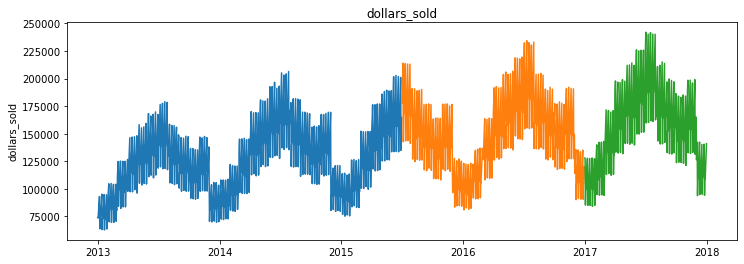

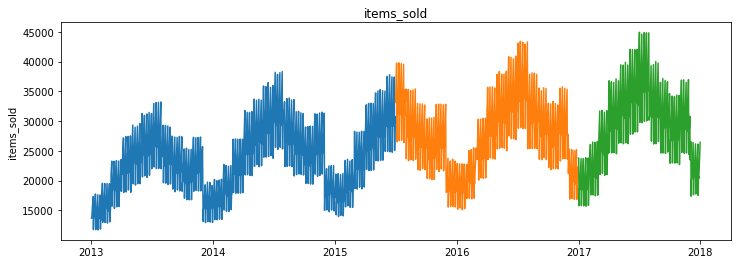

In [18]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    
    plt.ylabel(col)
    plt.title(col)
   

Before we try out different methods for forecasting sales and number of items sold, let's create a couple of functions that will be helpful in evaluating each of the methods that follow. 

`evaluate()` will compute the Mean Squared Error and the Rood Mean Squared Error to evaluate.  

In [19]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

`plot_and_eval()` will use the evaluate function and also plot train and test values with the predicted values in order to compare performance. 

In [20]:
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

Write `append_eval_df(model_type)` to append evaluation metrics for each model type, target variable, and metric type, along with the metric value into our `eval_df` data frame object. Which we will create an empty `eval_df` dataframe object to start. 

In [21]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [22]:
# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [23]:
eval_df

,model_type,target_var,rmse


## Forecast 

Forecasting is another word for predicting time series data. 

1. Last Observed Value: The future will look like the now
2. Simple Average: The future will look, on average, like history. 
3. Moving Average: The future will look, on average, like recent history. 
4. Holt's Linear Trend
5. Previous Cycle


### Last observed value

The simplest method for forecasting is to predict all future values to be the last observed value.  

**Make Predictions**

Dollars

In [25]:
#dollars sold and items sold should be...
train.tail(1)

,dollars_sold,items_sold
ds,,
2015-07-01,164573.2,30703.0


In [24]:
# now let's do it. Take the last item of dollars sold and assign to variable
dollars = round(train['dollars_sold'][-1:][0],2)
dollars

164573.2

Items

In [26]:
# take the last item of dollars sold and assign to variable
items = round(train['items_sold'][-1:][0],2)
items

30703.0

In [27]:
yhat_df = pd.DataFrame({'dollars_sold': [dollars], 
                        'items_sold': [items]}, 
                      index = validate.index)

yhat_df.head()

,dollars_sold,items_sold
ds,,
2015-07-02,164573.2,30703.0
2015-07-03,164573.2,30703.0
2015-07-04,164573.2,30703.0
2015-07-05,164573.2,30703.0
2015-07-06,164573.2,30703.0


In [28]:
#last observed
yhat_df.describe()

,dollars_sold,items_sold
count,5.470000e+02,547.0
mean,1.645732e+05,30703.0
std,1.660437e-09,0.0
min,1.645732e+05,30703.0
25%,1.645732e+05,30703.0
50%,1.645732e+05,30703.0
75%,1.645732e+05,30703.0
max,1.645732e+05,30703.0


You can see, when peeking into yhat_df, that every predicted value is the same.  

**Plot Actual vs. Predicted Values**

Now, let's plot actual and predicted values

dollars_sold -- RMSE: 35402


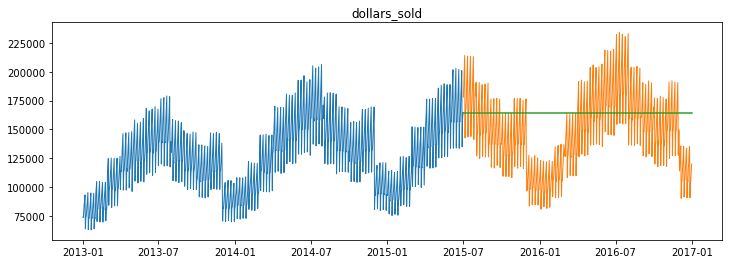

In [29]:
plot_and_eval('dollars_sold')

dollars_sold -- RMSE: 35402


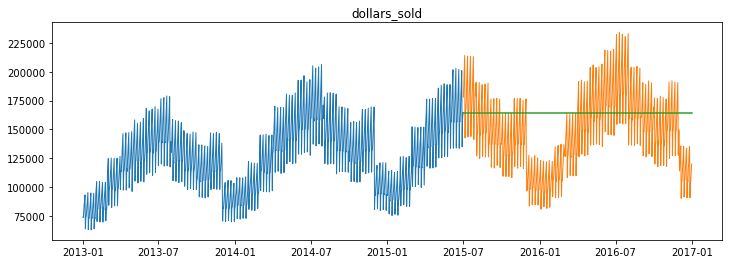

items_sold -- RMSE: 6621


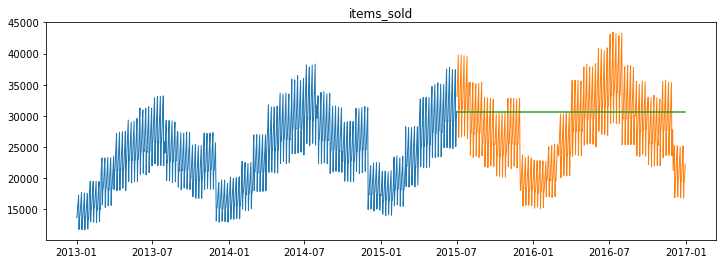

In [30]:
for col in train.columns:
    plot_and_eval(col)

**Evaluate** 

Evaluate using MSE and RMSE, and add evaluation metrics to `eval_df`

In [31]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402.0
1,last_observed_value,items_sold,6621.0


### Simple Average

Take the simple average of historical values and use that value to predict future values.   

This is a good option for an initial baseline. Every future datapoint (those in 'test') will be assigned the same value, and that value will be the overall mean of the values in train. 

**Make Predictions**

Dollars: establishing the value of the prediction we will make

In [32]:
# compute simple average
dollars = round(train['dollars_sold'].mean(),2)
dollars

127517.85

Items: establishing the value of the prediction we will make

In [33]:
items = round(train['items_sold'].mean(),2)
items

23717.94

Apply predictions to our observations

In [34]:
def make_predictions():
    yhat_df = pd.DataFrame({'dollars_sold': [dollars],
                           'items_sold':[items]},
                          index = validate.index)
    return yhat_df

In [35]:
yhat_df = make_predictions()

In [36]:
yhat_df.head()

,dollars_sold,items_sold
ds,,
2015-07-02,127517.85,23717.94
2015-07-03,127517.85,23717.94
2015-07-04,127517.85,23717.94
2015-07-05,127517.85,23717.94
2015-07-06,127517.85,23717.94


In [37]:
yhat_df.describe()

,dollars_sold,items_sold
count,5.470000e+02,5.470000e+02
mean,1.275179e+05,2.371794e+04
std,7.865227e-10,6.918487e-11
min,1.275179e+05,2.371794e+04
25%,1.275179e+05,2.371794e+04
50%,1.275179e+05,2.371794e+04
75%,1.275179e+05,2.371794e+04
max,1.275179e+05,2.371794e+04


**Plot Actual vs. Predicted Values**

Now, let's plot and evaluate the performance of our time series model using **Simple Average**

dollars_sold -- RMSE: 39664


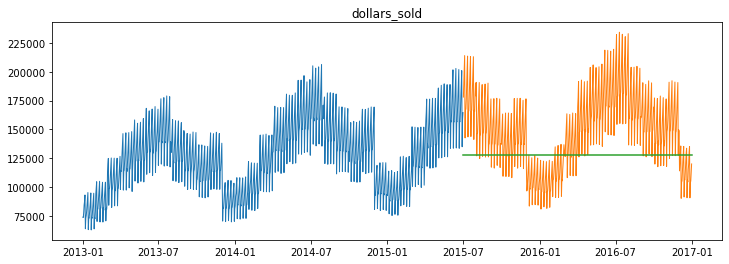

items_sold -- RMSE: 7378


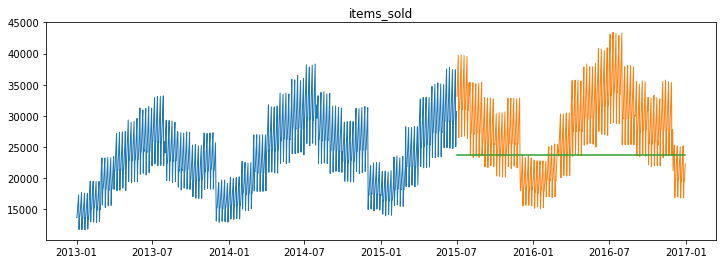

In [38]:
for col in train.columns:
    plot_and_eval(col)

**Evaluate**

Evaluate using MSE and RMSE, and add evaluation metrics to `eval_df`

In [39]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                            target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402.0
1,last_observed_value,items_sold,6621.0
2,simple_average,dollars_sold,39664.0
3,simple_average,items_sold,7378.0


### Moving Average

In this example, we will use a 30-day moving average to forecast. In other words, the average over the last 30-days will be used as the forecasted value. 

In [ ]:
# demonstrate that the mean of the first 30 days 
# is equal to rolling(30) on day 30

print(train['dollars_sold'].
print(train['dollars_sold'].

**Make Predictions**

In [40]:
period = 30 

# take 30 day rolling average, then take the last element and that will the one that propogates 
# forward as our prediction. 
dollars = round(train['dollars_sold'].rolling(period).mean()[-1],2)
items = round(train['items_sold'].rolling(period).mean()[-1],2)
print(dollars, items)

168957.91 31432.77


In [41]:
yhat_df = make_predictions()
yhat_df.head()

,dollars_sold,items_sold
ds,,
2015-07-02,168957.91,31432.77
2015-07-03,168957.91,31432.77
2015-07-04,168957.91,31432.77
2015-07-05,168957.91,31432.77
2015-07-06,168957.91,31432.77


**Plot Actual vs. Predicted Values**

Now, let's plot and evaluate the performance of our time series model using **Moving Average**

dollars_sold -- RMSE: 37378


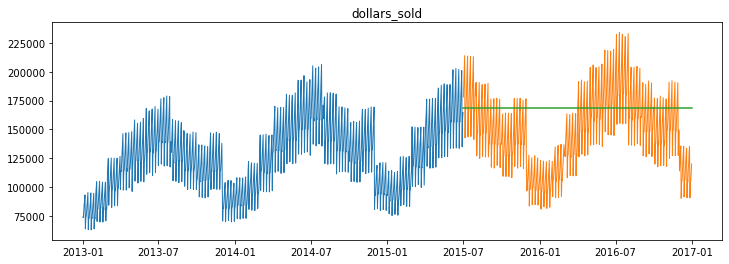

items_sold -- RMSE: 6954


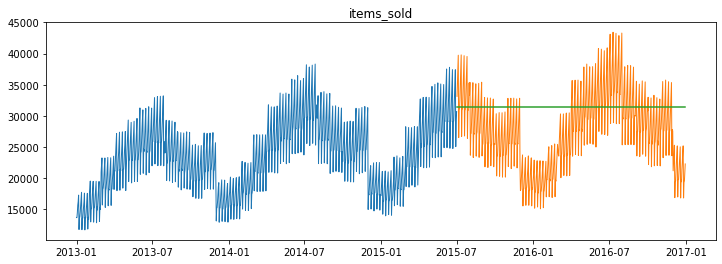

In [42]:
for col in train.columns:
    plot_and_eval(col)

**Evaluate**

Evaluate using MSE and RMSE, and add evaluation metrics to `eval_df`

In [43]:
for col in train.columns:
    eval_df = append_eval_df(model_type = '30d_moving_avg', 
                            target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402.0
1,last_observed_value,items_sold,6621.0
2,simple_average,dollars_sold,39664.0
3,simple_average,items_sold,7378.0
4,30d_moving_avg,dollars_sold,37378.0
5,30d_moving_avg,items_sold,6954.0


Let's try out several other values for periods:

In [44]:
periods = [4, 12, 26, 52, 104]

for p in periods: 
    dollars = round(train['dollars_sold'].rolling(p).mean()[-1], 2)
    items = round(train['items_sold'].rolling(p).mean()[-1],2)
    yhat_df = make_predictions()
    model_type = str(p) + 'd_moving_avg'
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type, 
                                 target_var = col)

In [45]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402.0
1,last_observed_value,items_sold,6621.0
2,simple_average,dollars_sold,39664.0
3,simple_average,items_sold,7378.0
4,30d_moving_avg,dollars_sold,37378.0
5,30d_moving_avg,items_sold,6954.0
6,4d_moving_avg,dollars_sold,35515.0
7,4d_moving_avg,items_sold,6592.0
8,12d_moving_avg,dollars_sold,37644.0
9,12d_moving_avg,items_sold,6992.0


Which is best so far? 

In [46]:
min_items_rmse = eval_df[eval_df.target_var=='items_sold']['rmse'].min()

min_dollars_rmse = eval_df[eval_df.target_var=='dollars_sold']['rmse'].min()

eval_df[eval_df.rmse==min_items_rmse]

,model_type,target_var,rmse
15,104d_moving_avg,items_sold,6101.0


In [47]:
eval_df[eval_df.rmse==min_dollars_rmse]

,model_type,target_var,rmse
14,104d_moving_avg,dollars_sold,32803.0


### Holt's Linear Trend


Exponential smoothing applied to both the average and the trend (slope).  

- $\alpha$ / smoothing_level: smoothing parameter for mean. Values closer to 1 will have less of a smoothing effect and will give greater weight to recent values.   
- $\beta$ / smoothing_slope: smoothing parameter for the slope. Values closer to 1 will give greater weight to recent slope/values. 



**Seasonal Decomposition**


First, let's take a look at the seasonal decomposition for each target. 

In [48]:
import statsmodels.api as sm

items_sold 



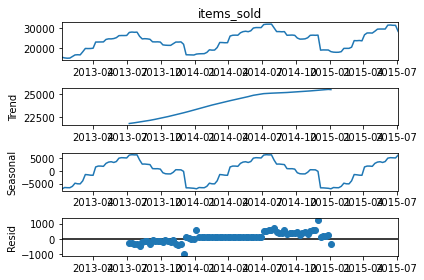

In [49]:
print(col, '\n')
sm.tsa.seasonal_decompose(train[col].resample('W').mean()).plot()
plt.show()

dollars_sold 



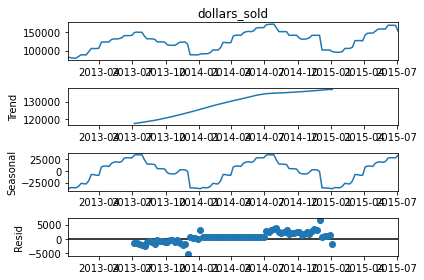

items_sold 



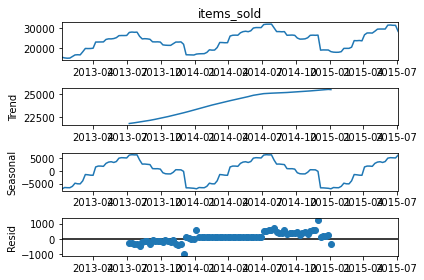

In [50]:
for col in train.columns:
    print(col, '\n')
    sm.tsa.seasonal_decompose(train[col].resample('W').mean()).plot()
    plt.show()

#### Basic Holt's Linear Trend

**Make Predictions**

Now, like we would when using sklearn, we will create the Holt object, fit the model, and make predictions. 

Holt: 

- exponential = True/False (exponential vs. linear growth, additive vs. multiplicative)
- damped $\phi$ = True/False: with Holt, forecasts will increase or decrease indefinitely into the future.  To avoid this, use the Damped trend method which has a damping parameter 0< ϕ <1. 


fit: 

- smoothing_level ($\alpha$): value between (0,1)
- smoothing_slope ($\beta$): value between (0,1)
- optimized: use the auto-optimization that allow statsmodels to automatically find an optimized value for us. 

In [51]:
# doing this in a loop for each column
for col in train.columns:
    model = Holt(train[col], exponential=False, damped=True)
    model = model.fit(optimized=True)
    yhat_items = model.predict(start= validate.index[0],
                              end=validate.index[-1])
    yhat_df[col] = round(yhat_items,2)

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [52]:
yhat_df

,dollars_sold,items_sold
ds,,
2015-07-02,170207.53,31656.49
2015-07-03,170328.01,31678.93
2015-07-04,170447.29,31701.15
2015-07-05,170565.37,31723.15
2015-07-06,170682.27,31744.93
...,...,...
2016-12-26,182204.03,33891.30
2016-12-27,182204.54,33891.40
2016-12-28,182205.05,33891.50


To practice the code before putting in a loop, as above...

In [53]:
col = 'dollars_sold'
# create the Holt object 
model = Holt(train[col], exponential=False, damped=True)
# fit the model 
model = model.fit(optimized=True)
# make predictions for each date in validate 
yhat_items = model.predict(start = validate.index[0],
                           end = validate.index[-1])
# add predictions to yhat_df
yhat_df[col] = round(yhat_items, 2)

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [54]:
yhat_df

,dollars_sold,items_sold
ds,,
2015-07-02,170207.53,31656.49
2015-07-03,170328.01,31678.93
2015-07-04,170447.29,31701.15
2015-07-05,170565.37,31723.15
2015-07-06,170682.27,31744.93
...,...,...
2016-12-26,182204.03,33891.30
2016-12-27,182204.54,33891.40
2016-12-28,182205.05,33891.50


**Plot Actual vs. Predicted Values**

dollars_sold -- RMSE: 44226


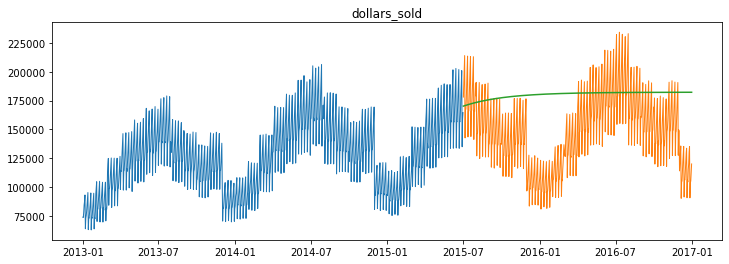

items_sold -- RMSE: 8225


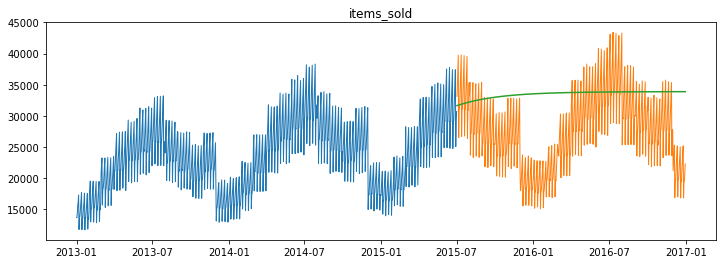

In [55]:
for col in train.columns:
    plot_and_eval(target_var = col)

**Evaluate**

In [56]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_optimized', 
                            target_var = col)

In [57]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
15,104d_moving_avg,items_sold,6101.0
13,52d_moving_avg,items_sold,6563.0
7,4d_moving_avg,items_sold,6592.0
1,last_observed_value,items_sold,6621.0
5,30d_moving_avg,items_sold,6954.0
9,12d_moving_avg,items_sold,6992.0
11,26d_moving_avg,items_sold,7004.0
3,simple_average,items_sold,7378.0
17,holts_optimized,items_sold,8225.0
14,104d_moving_avg,dollars_sold,32803.0


Let's do another model, changing some hyperparameters. 


In [59]:
for col in train.columns:
    model = Holt(train[col], exponential=False)
    model = model.fit(smoothing_level=0.1,
                      smoothing_slope = 0.1,
                      optimized=False)
    yhat_items = model.predict(start = validate.index[0],
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


dollars_sold -- RMSE: 34700


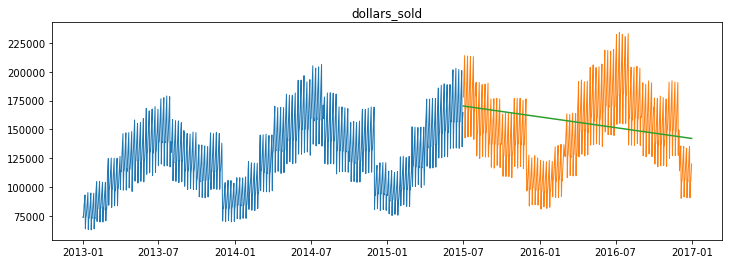

items_sold -- RMSE: 6464


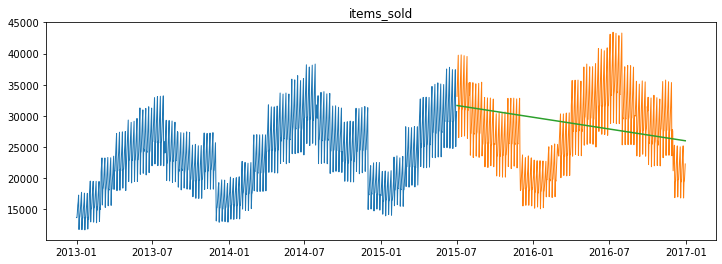

In [60]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [61]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_.1', 
                            target_var = col)
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
15,104d_moving_avg,items_sold,6101.0
19,holts_.1,items_sold,6464.0
13,52d_moving_avg,items_sold,6563.0
7,4d_moving_avg,items_sold,6592.0
1,last_observed_value,items_sold,6621.0
5,30d_moving_avg,items_sold,6954.0
9,12d_moving_avg,items_sold,6992.0
11,26d_moving_avg,items_sold,7004.0
3,simple_average,items_sold,7378.0
17,holts_optimized,items_sold,8225.0


### Predict Based on Previous Cycle

Take all the 2016 data points, compute the daily delta, year-over-year, average that delta over all the days, and adding that average to the previous year's value on a day will give you the forecast for that day. 

If a primary cycle is weekly, then you may want to do this on a week-over-week cadence. 

In the below example:  
1. Compute the 365 average year over year differences from 2013 through 2015
2. Add that average delta to the values during 2015. 
3. Set the index in your yhat dataframe to represent the dates those predictions are make for. 

Let's get started....

**Re-split data**

In [62]:
train = df[:'2015']
validate = df['2016']
test = df['2017']

print(train.shape)
print(validate.shape)
print(test.shape)

train.head()
train.tail()

(1095, 2)
(365, 2)
(365, 2)


,dollars_sold,items_sold
ds,,
2015-12-27,125125.86,23268.0
2015-12-28,84297.45,15569.0
2015-12-29,98602.75,18403.0
2015-12-30,97773.10,18191.0
2015-12-31,103969.42,19377.0


**Make Predictions**

In [63]:
# finding the year-over-year difference for each day from 2013 to 2015
# taking the mean, and then adding that value to the daily 2015 values. 

# find yoy diff. from 2013-2014 and 2014-2015, take the mean, and add to each value in 2015. 
yhat_df = train['2015'] + train.diff(365).mean()

Back to predictions

In [64]:
train.loc['2015'].head()

,dollars_sold,items_sold
ds,,
2015-01-01,92586.37,17226.0
2015-01-02,101119.52,18719.0
2015-01-03,106494.05,19798.0
2015-01-04,113745.51,21101.0
2015-01-05,76800.69,14235.0


In [65]:
yhat_df.head()

,dollars_sold,items_sold
ds,,
2015-01-01,104337.620493,19411.813699
2015-01-02,112870.770493,20904.813699
2015-01-03,118245.300493,21983.813699
2015-01-04,125496.760493,23286.813699
2015-01-05,88551.940493,16420.813699


In [66]:
# let's peek into the prediction we will make for 1/1/2016
# by comparing the predicted value 
# (2015 value + year-over-year average difference)
# to the actual 1/1/2016 value
pd.concat([yhat_df.head(1), validate.head(1)])

,dollars_sold,items_sold
ds,,
2015-01-01,104337.620493,19411.813699
2016-01-01,107875.260000,20158.000000


In [67]:
# set yhat_df to index of validate
yhat_df.index = validate.index

In [68]:
yhat_df.describe()

,dollars_sold,items_sold
count,365.000000,365.000000
mean,152236.991370,28314.271233
std,31264.033981,5816.407123
min,87009.270493,16153.813699
25%,128679.520493,23977.813699
50%,150024.320493,27913.813699
75%,177535.990493,33022.813699
max,225791.620493,41979.813699


In [69]:
yhat_df.head()

,dollars_sold,items_sold
ds,,
2016-01-01,104337.620493,19411.813699
2016-01-02,112870.770493,20904.813699
2016-01-03,118245.300493,21983.813699
2016-01-04,125496.760493,23286.813699
2016-01-05,88551.940493,16420.813699


In [70]:
yhat_df.shape

(365, 2)

**Plot and Evaluate**

dollars_sold -- RMSE: 28087


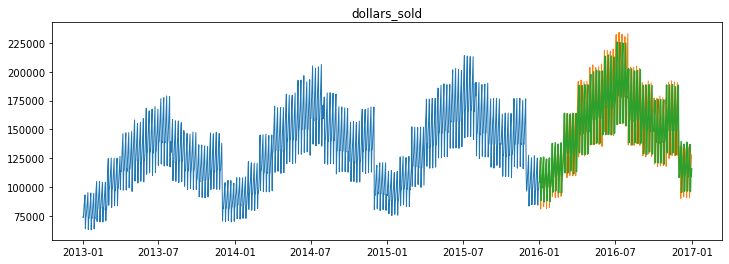

items_sold -- RMSE: 5223


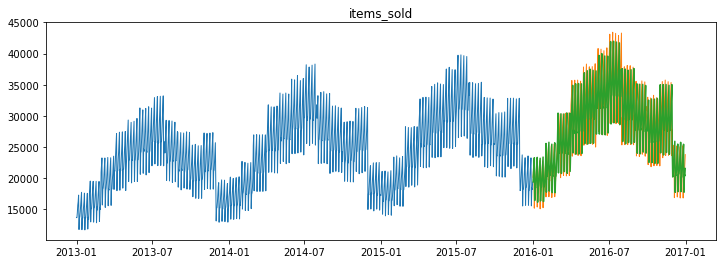

In [71]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = "previous_year", 
                            target_var = col)

## Conclusion

Which model did the best? 

In [72]:
dollars_min_rmse = eval_df.groupby('target_var')['rmse'].min()[0]

items_min_rmse = eval_df.groupby('target_var')['rmse'].min()[1]

# find which model that is
eval_df[((eval_df.rmse == dollars_min_rmse) | 
         (eval_df.rmse == items_min_rmse))]

,model_type,target_var,rmse
20,previous_year,dollars_sold,28087.0
21,previous_year,items_sold,5223.0


Let's test it out on our out-of-sample data

We will be using train + validate to predict test. 

In [73]:
yhat_df = validate + train.diff(365).mean()
yhat_df.index = test.index

In [74]:
yhat_df

,dollars_sold,items_sold
ds,,
2017-01-01,119626.510493,22343.813699
2017-01-02,126081.680493,23465.813699
2017-01-03,134896.160493,25096.813699
2017-01-04,92625.220493,17384.813699
2017-01-05,107181.150493,19991.813699
...,...,...
2017-12-27,115409.140493,21526.813699
2017-12-28,117065.190493,21745.813699
2017-12-29,124973.100493,23296.813699


In [75]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5)
    plt.title(target_var)
    plt.show()

In [76]:
rmse_dollars = sqrt(mean_squared_error(test['dollars_sold'], 
                                       yhat_df['dollars_sold']))

rmse_items = sqrt(mean_squared_error(test['items_sold'], 
                                       yhat_df['items_sold']))

In [77]:
print('rmse-dollars_sold: ', rmse_dollars)
print('rmse-items_sold: ', rmse_items)

rmse-dollars_sold:  27114.786014988113
rmse-items_sold:  5040.989142541608


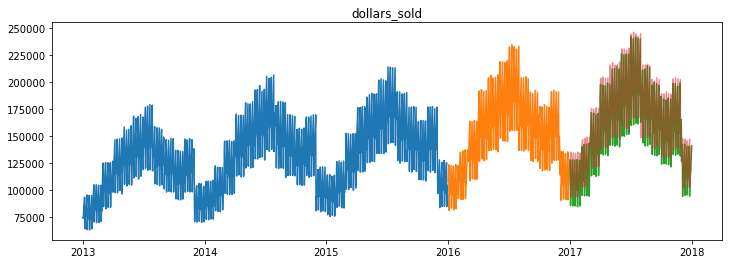

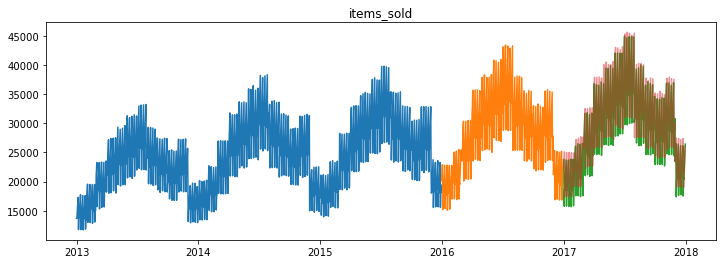

In [78]:
for col in train.columns:
    final_plot(col)

In [79]:
# to predict 2018

yhat_df = test + train.diff(365).mean()

yhat_df.index = test.index + pd.Timedelta('1Y')

In [80]:
yhat_df.head()

,dollars_sold,items_sold
ds,,
2018-01-01 05:49:12,139013.960493,25894.813699
2018-01-02 05:49:12,97081.230493,17957.813699
2018-01-03 05:49:12,112140.900493,20835.813699
2018-01-04 05:49:12,111205.840493,20695.813699
2018-01-05 05:49:12,119365.050493,22080.813699


In [81]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5)
    plt.title(target_var)
    plt.show()

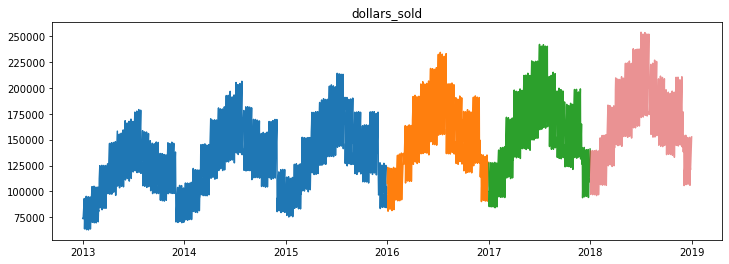

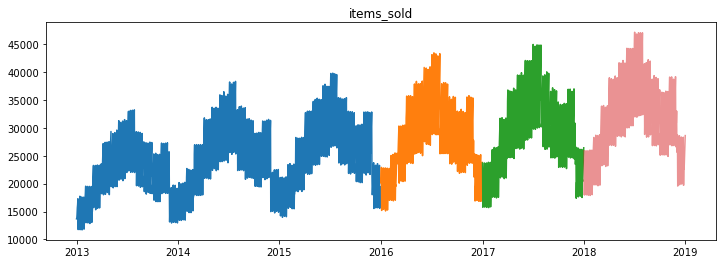

In [82]:
for col in train.columns:
    final_plot(col)

## Exercises

The end result of this exercise should be a Jupyter notebook named `model`.

Using [saas.csv](https://ds.codeup.com/saas.csv) or log data from API usage or store_item_sales

1. Split data (train/test) and resample by any period, except daily, and aggregate using the sum. 
2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
    - Simple Average
    - Moving Average
    - Holt's Linear Trend Model
    - Based on previous year/month/etc., this is up to you.

Optional: Using store item demand

1. Predict 2018 total **monthly** sales for a single store and/or item by creating a model using prophet.
2. Return a dataframe with the month, store_id, y-hat, and the confidence intervals (y-hat lower, y-hat upper).
3. Plot the 2018 monthly sales predictions.